In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Import Pythia Dataset

In [2]:
with uproot.open("/home/lvaughan/Pythia/pythia/PU_dataset/dataset_mu60.root:pythia") as f:
    trk_pt = f["pT"].array()
    trk_eta = f["eta"].array()
    trk_phi = f["phi"].array()
    trk_label = f["label"].array()
    trk_q = f["q"].array()
with uproot.open("/home/lvaughan/Pythia/pythia/PU_dataset/dataset_mu60.root:fastjet") as f:
    jet_pt = f["jet_pt"].array()
    jet_eta = f["jet_eta"].array()
    jet_phi = f["jet_phi"].array()
    trk_ID = f["trk_ID"].array()

### Define Jet Class

In [3]:
class Jet:
    def __init__(self, jet_features, trk_features, trk_labels):
        self.jet_features = jet_features
        self.trk_features = trk_features
        self.trk_labels = trk_labels
        
    def get_label(self):
        sum_pt_hs = 0
        sum_pt_pu = 0.0000001
        for trk in range(len(self.trk_features)):
            if self.trk_labels[trk]==-1:
                sum_pt_hs+=self.trk_features[trk,0]**2
            else:
                sum_pt_pu+=self.trk_features[trk,0]**2
        return sum_pt_hs / (sum_pt_hs + sum_pt_pu)
    
    def set_label(self, label):
        self.label = np.float32(label)
        
    def convert_to_tensor(self):
        self.trk_features = torch.from_numpy(self.trk_features)
        self.jet_features = torch.from_numpy(self.jet_features)
        self.label = torch.tensor(self.label).reshape([1])

### Read Raw Data into Jet Class

Processing:  44600  /  44634
Training samples:  26780
Validation samples:  4463
Testing samples:  11142


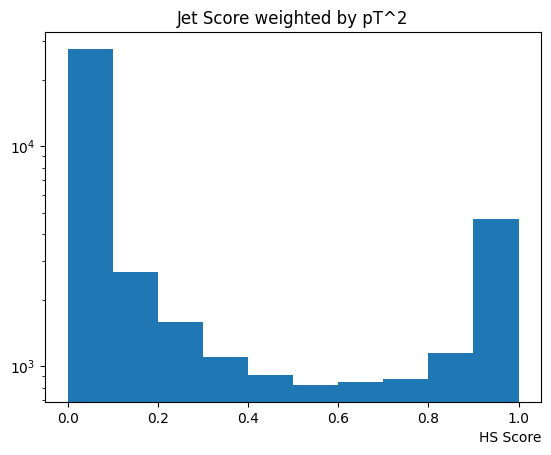

In [4]:
num_jets = len(jet_pt)

Jets = []

for jet in range(num_jets):
    if jet%100==0:
        print("Processing: ", jet, " / ", num_jets, end="\r")
    if jet_eta[jet] > 4:
        continue
    jet_feats = np.array([jet_pt[jet],jet_eta[jet],jet_phi[jet]], dtype=np.float32)
    trk_feats = np.empty((0,4), dtype=np.float32)
    for trk in trk_ID[jet]:
        # ALTAS uses 400MeV cut
        if trk_pt[trk] < 0.4:
            continue
        # Implement eta cuts on tracks
        if trk_eta[trk] > 4:
            continue
        # Skip neutral particles
        if trk_q[trk]==0:
            continue
        trk_feats = np.vstack((trk_feats, np.array([trk_pt[trk], trk_eta[trk], trk_phi[trk], trk_label[trk]], dtype=np.float32)))
    Jets.append(Jet(jet_feats,trk_feats[:,0:3],trk_feats[:,-1]))
    
random.shuffle(Jets)

Jets_training = Jets[0:int(0.6*num_jets)]
Jets_validation = Jets[int(0.6*num_jets):int(0.7*num_jets)]
Jets_testing = Jets[int(0.7*num_jets):-1]

print()
print("Training samples: ", len(Jets_training))
print("Validation samples: ", len(Jets_validation))
print("Testing samples: ", len(Jets_testing))

label = []
for jet in Jets:
    jet.set_label(jet.get_label())
    jet.convert_to_tensor()
    label.append(float(jet.label[0].numpy()))
    
plt.hist(label)
plt.title("Jet Score weighted by pT^2")
plt.xlabel("HS Score",loc='right')
plt.yscale('log')

### Define DataLoader

In [5]:
def Batch_Data(Jet_List):
    # Determine max number of tracks per jet
    max_list = []
    for jet in Jet_List:
        max_list.append(len(jet.trk_features))
    max_num_trks = max(max_list)

    # Loop through number of minibatches and cat padded tensors
    minibatch_size = 128
    minibatches = int(len(Jet_List)/minibatch_size)
    batched_data_jets = []
    batched_data_trks = []
    labels = []

    for i in range(minibatches):

        batch_tensors_trk = []
        batch_tensors_jet = []
        batch_labels = []

        index_start = i*minibatch_size
        index_stop = (i+1)*minibatch_size

        for jet in Jet_List[index_start:index_stop]:
            out_jet = torch.unsqueeze(jet.jet_features,0)
            batch_tensors_jet.append(out_jet)
            batch_labels.append(jet.label)

            pad = (0,0,0,max_num_trks-len(jet.trk_features))
            out_trk = F.pad(jet.trk_features,pad)
            out_trk = torch.unsqueeze(out_trk,0)
            batch_tensors_trk.append(out_trk)    

        batch_jet = torch.cat(batch_tensors_jet)
        batched_data_jets.append(batch_jet)
        batch_trk = torch.cat(batch_tensors_trk)
        batched_data_trks.append(batch_trk)
        batch_labels = torch.cat(batch_labels).reshape([minibatch_size,1])
        labels.append(batch_labels)
        
    return batched_data_jets, batched_data_trks, labels

### Define Model

In [6]:
class Model(nn.Module):  
    def __init__(self):
        super(Model, self).__init__()   
        
        self.embed_dim = 64
        self.num_heads = 8
        self.num_feats = 3
        
        self.jet_initializer = nn.Linear(self.num_feats, self.embed_dim)
        self.trk_initializer = nn.Linear(self.num_feats, self.embed_dim)
        
        self.multihead_attn = nn.MultiheadAttention(self.embed_dim, self.num_heads,batch_first=True)
        
        self.regression = nn.Linear(self.embed_dim*2, 1)
        
    def forward(self, jet_batch, trk_batch):
        trk_init = F.relu(self.trk_initializer(trk_batch))
        jet_init = F.relu(self.jet_initializer(jet_batch))
        
        query = trk_init
        key = trk_init
        value = trk_init
        
        trk_embedding, trk_weights = self.multihead_attn(query, key, value)
        
        trk_aggregated = trk_embedding.sum(dim=1)
            
        jet_embedding = torch.cat((jet_init, trk_aggregated),1)
             
        output = F.sigmoid(self.regression(jet_embedding))
        
        return output, trk_weights

### Define Training Loop

In [7]:
def train(model, data, epochs=40):
    train_data, validation_data = data
    
    jets_train_batched, trks_train_batched, train_labels = Batch_Data(train_data)
    jets_val_batched, trks_val_batched, val_labels = Batch_Data(validation_data)
    
    history = []
    num_train = len(train_labels)
    num_val = len(val_labels)
    
    for e in range(epochs):
        model.train()
        cumulative_loss_train = 0
        for batch in range(num_train):
            optimizer.zero_grad()
            output, weights = model(jets_train_batched[batch].to(device), trks_train_batched[batch].to(device))
            loss=loss_fn(output, train_labels[batch].to(device))
            loss.backward()
            optimizer.step()
            cumulative_loss_train+=loss.detach().cpu().numpy().mean()
        cumulative_loss_train = cumulative_loss_train / num_train
        
        model.eval()
        cumulative_loss_val = 0
        for batch in range(num_val):
            output, weights = model(jets_val_batched[batch].to(device), trks_val_batched[batch].to(device))
            loss=loss_fn(output, val_labels[batch].to(device))
            cumulative_loss_val+=loss.detach().cpu().numpy().mean()
        cumulative_loss_val = cumulative_loss_val / num_val
        
        history.append([cumulative_loss_train, cumulative_loss_val])

        print('Epoch:',e,'\tTrain Loss:',round(cumulative_loss_train,6),'\tVal Loss:',round(cumulative_loss_val,6))

    return history

### Train Model

GPU Available:  True
cuda:0

Epoch: 0 	Train Loss: 0.256745 	Val Loss: 0.131904
Epoch: 1 	Train Loss: 0.126321 	Val Loss: 0.116825
Epoch: 2 	Train Loss: 0.11093 	Val Loss: 0.103133
Epoch: 3 	Train Loss: 0.098277 	Val Loss: 0.092399
Epoch: 4 	Train Loss: 0.088283 	Val Loss: 0.085036
Epoch: 5 	Train Loss: 0.080514 	Val Loss: 0.078908
Epoch: 6 	Train Loss: 0.074182 	Val Loss: 0.073815
Epoch: 7 	Train Loss: 0.069236 	Val Loss: 0.070462
Epoch: 8 	Train Loss: 0.065792 	Val Loss: 0.067846
Epoch: 9 	Train Loss: 0.063356 	Val Loss: 0.065927
Epoch: 10 	Train Loss: 0.061338 	Val Loss: 0.064409
Epoch: 11 	Train Loss: 0.059498 	Val Loss: 0.063186
Epoch: 12 	Train Loss: 0.057832 	Val Loss: 0.062133
Epoch: 13 	Train Loss: 0.056295 	Val Loss: 0.061135
Epoch: 14 	Train Loss: 0.054732 	Val Loss: 0.060203
Epoch: 15 	Train Loss: 0.053043 	Val Loss: 0.059293
Epoch: 16 	Train Loss: 0.051265 	Val Loss: 0.058373
Epoch: 17 	Train Loss: 0.049585 	Val Loss: 0.057582
Epoch: 18 	Train Loss: 0.048218 	Val Loss: 0.0

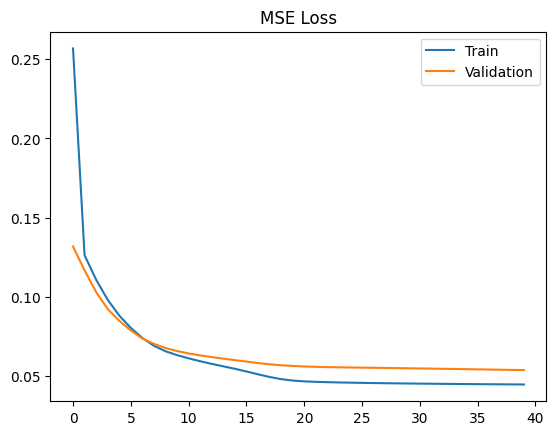

In [8]:
print("GPU Available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print()

model = Model()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00001)
loss_fn = nn.MSELoss()
history = train(model, [Jets_training, Jets_validation])
plt.plot(history)
plt.title('MSE Loss')
plt.legend(['Train','Validation'])
plt.show()

### Visualize Attention Scores

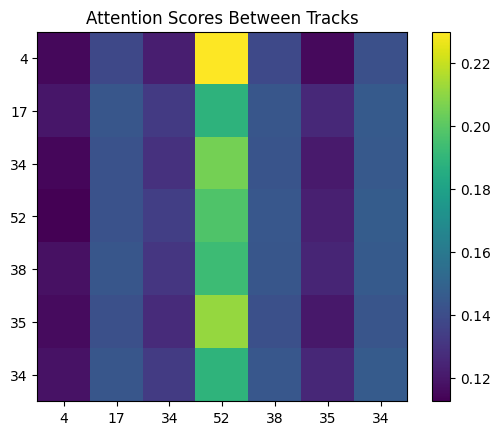

In [9]:
jet_no = 0

model.eval()
output, weights = model(torch.unsqueeze(Jets_testing[jet_no].jet_features,0).to(device), torch.unsqueeze(Jets_testing[jet_no].trk_features,0).to(device))

plt.imshow(weights[0].detach().cpu().numpy())
ticks = [x for x in range(len(Jets_testing[jet_no].trk_features))]
tick_labels = []
for trk in range(len(Jets_testing[jet_no].trk_features)):
    tick_labels.append(int(Jets_testing[jet_no].trk_labels[trk]))
plt.xticks(ticks, tick_labels)
plt.yticks(ticks, tick_labels)
plt.colorbar()
plt.title("Attention Scores Between Tracks")
plt.show()

### Evaluate Model

Train Loss:	 0.044849193766356654
Val Loss:	 0.053920810056083346
Test Loss:	 0.05407935967561842


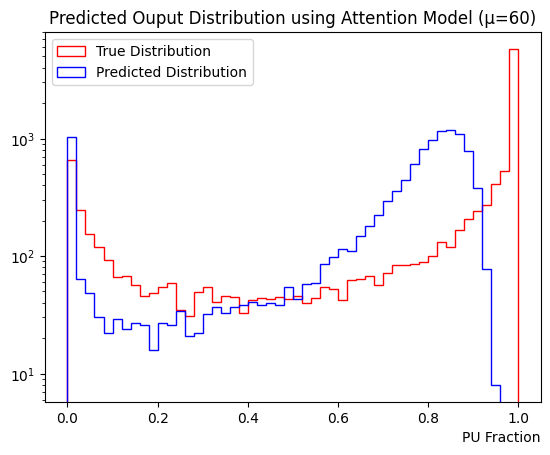

In [11]:
model.eval()
cumulative_loss_test = 0
predicted_labels = []
true_labels = []

jets_test_batched, trks_test_batched, test_labels = Batch_Data(Jets_testing)

for batch in range(len(test_labels)):
    output, weights = model(jets_test_batched[batch].to(device), trks_test_batched[batch].to(device))
    
    for i in range(output.shape[0]):        
        predicted_labels.append(1-float(output[i][0].detach().cpu().numpy()))
        true_labels.append(1-float(test_labels[batch][i][0].detach().numpy()))
    
    loss=loss_fn(output, test_labels[batch].to(device))
    cumulative_loss_test+=loss.detach().cpu().numpy().mean()
    
cumulative_loss_test = cumulative_loss_test / len(test_labels)
    
print("Train Loss:\t", history[-1][0])
print("Val Loss:\t", history[-1][1])
print("Test Loss:\t", cumulative_loss_test)

plt.hist(true_labels,histtype='step',color='r',label='True Distribution',bins=50,range=(0,1))
plt.hist(predicted_labels,histtype='step',color='b',label='Predicted Distribution',bins=50,range=(0,1))
plt.title("Predicted Ouput Distribution using Attention Model (\u03BC=60)")
plt.legend()
plt.yscale('log')
plt.xlabel('PU Fraction',loc='right')
plt.show()